Dataset contains Reviews of movies and a binary classification of the movies as output. The words of the reviews are indices of a dictionary.

In [1]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten, Conv1D, Conv2D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords

/Users/franzi/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package punkt to /Users/franzi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/franzi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from keras.datasets import imdb

num_words = 1000
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=num_words,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [3]:
def n_hot_vector(sequence, num_words):
    n_hot_v = np.zeros(num_words)
    
    indices = np.unique(sequence)
    n_hot_v[indices] = 1
    return n_hot_v  

def n_hot_matrix(input_length, num_words, sequences):
    n_hot_m = np.zeros((input_length, num_words))
    
    for i in range(input_length):
        indices = np.unique(sequences[i])
        n_hot_m[i, indices] = 1
    
    return n_hot_m

In [4]:
# #one-hot encoding of sentences
# x_train_enc = n_hot_matrix(x_train.shape[0], 1000, x_train)
# x_test_enc = n_hot_matrix(x_test.shape[0], 1000, x_train)

In [5]:
#one-hot encoding of sentences
tokenizer = Tokenizer(num_words=num_words)
x_train_enc = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test_enc = tokenizer.sequences_to_matrix(x_test, mode='binary')

In [6]:
num_classes = 2
y_train_enc = to_categorical(y_train, num_classes)
y_test_enc = to_categorical(y_test, num_classes)

In [7]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(x_train_enc.shape[1], ), kernel_regularizer='l2'))
model.add(Dense(2, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                50050     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 50,152
Trainable params: 50,152
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
model.fit(x_train_enc, y_train_enc, validation_data=(x_test_enc, y_test_enc),
          epochs=10, batch_size=128)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 92us/step - loss: 0.6756 - acc: 0.8047 - val_loss: 0.4686 - val_acc: 0.8393
Epoch 2/10
25000/25000 [==============================] - 1s 50us/step - loss: 0.4426 - acc: 0.8477 - val_loss: 0.4347 - val_acc: 0.8459
Epoch 3/10
25000/25000 [==============================] - 1s 48us/step - loss: 0.4272 - acc: 0.8473 - val_loss: 0.4205 - val_acc: 0.8502
Epoch 4/10
25000/25000 [==============================] - 1s 49us/step - loss: 0.4133 - acc: 0.8489 - val_loss: 0.4107 - val_acc: 0.8524
Epoch 5/10
25000/25000 [==============================] - 1s 48us/step - loss: 0.4065 - acc: 0.8523 - val_loss: 0.4132 - val_acc: 0.8463
Epoch 6/10
25000/25000 [==============================] - 1s 48us/step - loss: 0.4059 - acc: 0.8497 - val_loss: 0.4003 - val_acc: 0.8512
Epoch 7/10
25000/25000 [==============================] - 1s 48us/step - loss: 0.3991 - acc: 0.8543 - val_loss: 0.4007 - val_acc

#### Embedding

In [9]:
print np.max(np.concatenate(x_train))
print np.min(np.concatenate(x_train))
print len(np.unique(np.concatenate(x_train)))

999
1
998


In [10]:
# preparation of embedding layer

embeddings_index = {}
f = open(os.path.join('glove.6B', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [11]:
#get a dictionary with the 999 most common words

word_index = imdb.get_word_index()

ix_common_words = np.where(np.array(word_index.values()) < num_words)
keys_common_words = np.array(word_index.keys())[ix_common_words]
values_common_words = np.array(word_index.values())[ix_common_words]

most_common_words = dict()

for i, keys in enumerate(keys_common_words):
    most_common_words[keys] = values_common_words[i]

In [12]:
most_common_words['a']

3

In [13]:
EMBEDDING_DIM = 100

new_word_index = most_common_words

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in new_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [14]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

x_train_embedded = np.dot(x_train_enc, embedding_matrix)
x_test_embedded = np.dot(x_test_enc, embedding_matrix)
print x_train_embedded.shape
#x_train_embedded_2D = TSNE(n_components=2).fit_transform(x_train_embedded)

pca = PCA(n_components=2)
x_train_embedded_2D = pca.fit_transform(x_train_embedded)

(25000, 100)


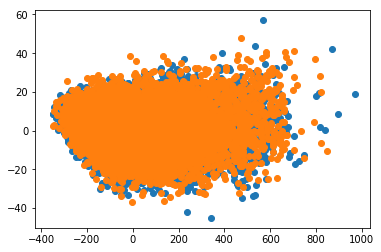

In [15]:
x_val = x_train_embedded_2D[:,0]
y_val = x_train_embedded_2D[:,1]

ix_class1 = np.where(y_train_enc[:,0] == 0)[0]
ix_class2 = np.where(y_train_enc[:,0] == 1)[0]

plt.scatter(x_val[ix_class1], y_val[ix_class1])
plt.scatter(x_val[ix_class2], y_val[ix_class2])

#### Embedding layer

In [16]:
EMBEDDING_DIM = 100

new_word_index = most_common_words

embedding_matrix = np.zeros((len(new_word_index) + 1, EMBEDDING_DIM))
for word, i in new_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [17]:


# embedding_layer = Embedding(len(new_word_index) + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=False)

In [18]:
# embedding_matrix.shape

In [21]:
MAX_SEQUENCE_LENGTH = x_train_enc.shape[1]

embedding_layer = Embedding(len(new_word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH, trainable = False)

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
#model.add(Dense(50, activation='relu', input_shape=(x_train_embedded.shape[1], )))
#model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# compile the model
from keras.optimizers import Adam
ad = Adam(lr=0.0001)
model.compile(optimizer=ad, loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         100000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 200002    
Total params: 300,002
Trainable params: 200,002
Non-trainable params: 100,000
_________________________________________________________________
None


In [22]:
model.fit(x_train_enc, y_train_enc, validation_data=(x_test_enc, y_test_enc),
          epochs=10, batch_size=128)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 21s 826us/step - loss: 0.4405 - acc: 0.8196 - val_loss: 0.3614 - val_acc: 0.8554
Epoch 2/10
25000/25000 [==============================] - 21s 831us/step - loss: 0.3372 - acc: 0.8641 - val_loss: 0.3347 - val_acc: 0.8611
Epoch 3/10
25000/25000 [==============================] - 22s 872us/step - loss: 0.3182 - acc: 0.8686 - val_loss: 0.3303 - val_acc: 0.8602
Epoch 4/10
25000/25000 [==============================] - 21s 825us/step - loss: 0.3097 - acc: 0.8724 - val_loss: 0.3257 - val_acc: 0.8615
Epoch 5/10
25000/25000 [==============================] - 20s 804us/step - loss: 0.3060 - acc: 0.8750 - val_loss: 0.3256 - val_acc: 0.8614
Epoch 6/10
25000/25000 [==============================] - 20s 799us/step - loss: 0.3040 - acc: 0.8745 - val_loss: 0.3269 - val_acc: 0.8605
Epoch 7/10
25000/25000 [==============================] - 21s 858us/step - loss: 0.3032 - acc: 0.8744 - val_loss: 0.

In [23]:
embedding_layer.get_weights()[0]

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.038194, -0.24487 ,  0.72812 , ..., -0.1459  ,  0.8278  ,
         0.27062 ],
       [-0.071953,  0.23127 ,  0.023731, ..., -0.71895 ,  0.86894 ,
         0.19539 ],
       ...,
       [-0.28177 , -0.22735 , -0.016857, ..., -0.19574 , -0.21571 ,
        -0.27263 ],
       [ 0.23182 , -0.35374 , -0.067178, ..., -0.34251 ,  0.87474 ,
         0.12929 ],
       [ 0.29673 , -0.19803 ,  0.95258 , ..., -0.081311, -0.070592,
         0.021297]], dtype=float32)

In [29]:
model.get_weights()[1].shape

(100000, 2)

#### No pretrained layer

In [30]:
embedding_layer = Embedding(len(new_word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)

In [31]:
MAX_SEQUENCE_LENGTH = x_train_enc.shape[1]

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
#model.add(Dense(50, activation='relu', input_shape=(x_train_embedded.shape[1], )))
#model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# compile the model
from keras.optimizers import Adam
ad = Adam(lr=0.0001)
model.compile(optimizer=ad, loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         100000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 200002    
Total params: 300,002
Trainable params: 300,002
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
model.fit(x_train_enc, y_train_enc, validation_data=(x_test_enc, y_test_enc),
          epochs=10, batch_size=128)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 25s 1ms/step - loss: 0.6318 - acc: 0.6962 - val_loss: 0.5512 - val_acc: 0.7625
Epoch 2/10
25000/25000 [==============================] - 23s 916us/step - loss: 0.4753 - acc: 0.8135 - val_loss: 0.4275 - val_acc: 0.8244
Epoch 3/10
25000/25000 [==============================] - 23s 915us/step - loss: 0.3922 - acc: 0.8428 - val_loss: 0.3950 - val_acc: 0.8252
Epoch 4/10
25000/25000 [==============================] - 23s 918us/step - loss: 0.3591 - acc: 0.8512 - val_loss: 0.3614 - val_acc: 0.8455
Epoch 5/10
25000/25000 [==============================] - 23s 910us/step - loss: 0.3390 - acc: 0.8602 - val_loss: 0.3535 - val_acc: 0.8475
Epoch 6/10
25000/25000 [==============================] - 24s 944us/step - loss: 0.3293 - acc: 0.8632 - val_loss: 0.3658 - val_acc: 0.8372
Epoch 7/10
25000/25000 [==============================] - 24s 940us/step - loss: 0.3220 - acc: 0.8640 - val_loss: 0.33

In [33]:
embedding_matrix2 = embedding_layer.get_weights()[0]

x_train_embedded = np.dot(x_train_enc, embedding_matrix2)
x_test_embedded = np.dot(x_test_enc, embedding_matrix2)
print x_train_embedded.shape
#x_train_embedded_2D = TSNE(n_components=2).fit_transform(x_train_embedded)

pca = PCA(n_components=2)
x_train_embedded_2D = pca.fit_transform(x_train_embedded)

(25000, 100)


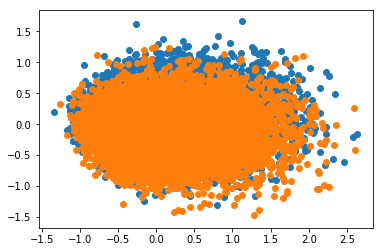

In [34]:
x_val = x_train_embedded_2D[:,0]
y_val = x_train_embedded_2D[:,1]

ix_class1 = np.where(y_train_enc[:,0] == 0)[0]
ix_class2 = np.where(y_train_enc[:,0] == 1)[0]

plt.scatter(x_val[ix_class1], y_val[ix_class1])
plt.scatter(x_val[ix_class2], y_val[ix_class2])

In [ ]:
#word_index = imdb.get_word_index()

# word2int = dict()

# for word, ix in word_index.items():
#     word2int[word] = ix

In [ ]:
# sentence = []
# for ix in x_train[0]:
#     sentence.append(int2word[ix])
# print sentence

In [ ]:
# # the word_index starts with number 1 and has 88584 entries in total, no number/value is missing

# print np.min(word_index.values())
# print np.max(word_index.values())
# print len(word_index.values())

In [ ]:
# # somehow number 3 is missing in x_train
# print np.where(np.concatenate(x_train) == 3)
# ix_3 = np.where(np.array(word_index.values()) == 3)[0][0]

# print word_index.keys()[ix_3]

In [ ]:
# #one-hot encoding of sentences
# tokenizer = Tokenizer(num_words=num_words)
# x_train_enc = tokenizer.sequences_to_matrix(x_train, mode='binary')
# x_test_enc = tokenizer.sequences_to_matrix(x_test, mode='binary')

In [ ]:
# #one-hot encoding of sentences
# tokenizer = Tokenizer(num_words=num_words + 1)
# x_train_enc2 = tokenizer.sequences_to_matrix(x_train, mode='binary')
# x_test_enc2 = tokenizer.sequences_to_matrix(x_test, mode='binary')